<a href="https://colab.research.google.com/github/lucas-fpaiva/AnalisePred_I/blob/main/Projeto/car_eval/classifier_car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

# Avaliar se o preço de compra do veículo é aceitável


In [69]:
import pandas as pd
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import seaborn as sns

from scipy.io.arff import loadarff 
from scipy.io import arff

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import precision_score as ps
from sklearn.metrics import recall_score as rs
from sklearn.metrics import f1_score as f1
from sklearn.metrics import accuracy_score as acs
from sklearn.metrics import auc, roc_auc_score
from sklearn.metrics import plot_confusion_matrix

from sklearn.feature_selection import RFE, SequentialFeatureSelector

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.datasets import make_classification
from ast import literal_eval

import warnings
warnings.filterwarnings('ignore')


In [30]:
def grid_best_model (model="DT", grid=""):
  #A função retorna o modelo com os melhores parametros, os melhores parametros e o melhor score
  scoring = 'f1'
    
  if model == "DT":
    gs_cv = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=grid['DT'], cv= 5, scoring=scoring, n_jobs=-1)
    gs_cv.fit(x_treino, y_treino)
    return DecisionTreeClassifier(**gs_cv.best_params_), gs_cv.best_params_
      
  if model=="PMC":
    gs_cv = GridSearchCV(estimator=MLPClassifier(), param_grid=grid['PMC'], cv= 5, scoring=scoring, n_jobs=-1)
    gs_cv.fit(x_treino, y_treino)
    return MLPClassifier(**gs_cv.best_params_), gs_cv.best_params_
    
  if model == "RF":
    gs_cv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid['RF'], cv= 5, scoring=scoring, n_jobs=-1)
    gs_cv.fit(x_treino, y_treino)
    return RandomForestClassifier(**gs_cv.best_params_), gs_cv.best_params_

  if model == "KNN":
    gs_cv = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=grid['KNN'], cv= 5, scoring=scoring, n_jobs=-1)
    gs_cv.fit(x_treino, y_treino)
    return KNeighborsClassifier(**gs_cv.best_params_), gs_cv.best_params_

  if model == "RL":
    gs_cv = GridSearchCV(estimator=LogisticRegression(), param_grid=grid['RL'], cv= 5, scoring=scoring, n_jobs=-1)
    gs_cv.fit(x_treino, y_treino)
    return LogisticRegression(**gs_cv.best_params_), gs_cv.best_params_
    #return LogisticRegression(), gs_cv.best_params_

  if model == "BNB":
    gs_cv = GridSearchCV(estimator=BernoulliNB(), param_grid=grid['BNB'], cv= 5, scoring=scoring, n_jobs=-1)
    gs_cv.fit(x_treino, y_treino)
    return BernoulliNB(**gs_cv.best_params_), gs_cv.best_params_

  if model == "SVM":
    gs_cv = GridSearchCV(estimator=SVC(), param_grid=grid['SVM'], cv= 5, scoring=scoring, n_jobs=-1)
    gs_cv.fit(x_treino, y_treino)
    return SVC(**gs_cv.best_params_), gs_cv.best_params_

  if model == "GB":
    gs_cv = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=grid['GB'], cv= 5, scoring=scoring, n_jobs=-1)
    gs_cv.fit(x_treino, y_treino)
    return GradientBoostingClassifier(**gs_cv.best_params_), gs_cv.best_params_
        
  
#Parâmetros do Grid
grid = {
    'RF':{ #based on: Discrete Simulation Optimization for Tuning Machine Learning Method Hyperparameters
        'n_estimators': [10, 100],
        'max_depth' : range(5, 50, 5),
        #'min_samples_split' : [2, 11],
        #'min_samples_leaf' : [1, 11],
        #'max_features' : [1,54],
        'criterion' :['gini', 'entropy'],
        'random_state' : [0]},

    'PMC':{ #based on: Discrete Simulation Optimization for Tuning Machine Learning Method Hyperparameters
        'hidden_layer_sizes': range(5, 50, 5),
        'learning_rate' : ['constant','adaptive'],
        'learning_rate_init' : [0.001, 0.01, 0.05],
        'max_iter': [200],
        'activation' : ['relu', 'tanh'],
        #'solver' : ['adam', 'sgd'],
        'random_state' : [0]},

    'DT':{ #based on: Random Forest
        'max_depth' : range(5, 50, 5),
        #'min_samples_split' : [2, 11],
        #'min_samples_leaf' : [1, 11],
        #'max_features' : [1,54],
        'criterion' :['gini', 'entropy'],
        'random_state' : [0]},

    'KNN':{ #based on:
        'n_neighbors': range(5, 50, 5),
        'weights': ['uniform', 'distance'],
        'metric' : ['manhattan', 'euclidean'],
        # 'algorithm':['kd_tree'] #algorithm{‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}
        },

    'RL':{ #based on: Logistic Regression Hyperparameter Optimization for Cancer Classification
        'penalty' : ['l1', 'l2', 'elasticnet'],
        'l1_ratio' : [0, 1],
        #'learning_rate' : ['constant', 'optimal', 'invscaling', 'adaptive'],
        #'eta0' : [0, 2],
        'tol' : [0.00001, 0.01], #Alpha
        'warm_start' : [True, False],
        'random_state' : [0]},

    'BNB':{ #based on:
        'alpha' : np.arange(0.0, 1.0, 0.05)},
    
    'SVM':{ #based on:
        'C' : [0.1,1,10],
        'kernel' : ['linear', 'poly', 'rbf'],
        #'gamma' : ['auto', 'scale'], #[0.001, 0.01, 0.1, 0.5, 1, 10, 100],
        'probability' : [True],
        'random_state' : [0]},
    
    'GB':{ #based on:
        'n_estimators': [10, 100],
        'max_depth' : [2, 3, 5, 7, 10],
        #'learning_rate' : [0.025, 0.05, 0.1, 0.2, 0.3],
        #'min_samples_split' : [2, 5, 10, 20],
        #'max_features' : ['log2', 'sqrt', 0.25, 1.0],
        #'subsample' : [0.15, 0.5, 0.75, 1.0],
        'random_state' : [0]}
}

In [31]:
def f_models (name,parameters):
    if name == 'DT':
        model = DecisionTreeClassifier(**parameters);
    elif name == 'RF':
        model = RandomForestClassifier(**parameters);
    elif name == 'KNN':
        model = KNeighborsClassifier(**parameters);
    elif name == 'RL':
        model = LogisticRegression(**parameters);
    elif name == 'SVM':
        model = SVC(**parameters);
    elif name == 'PMC':
        model = MLPClassifier(**parameters);
    elif name == 'BNB':
        model = BernoulliNB(**parameters);
    elif name == 'GB':
        model = GradientBoostingClassifier(**parameters);
    else :
        print('Model not found')
        model=None
    return model

In [32]:
def metrics (y_true, y_pred, y_pred_prob):
  return [acs(y_true, y_pred), f1(y_true, y_pred, average = 'macro'),
          roc_auc_score(y_true, y_pred_prob, average='macro', multi_class = 'ovr')]

In [ ]:
def select_feat_(x_treino,y_treino,model,n,features):

  if n =='All':
    best_feats = features

  else:
    

    #model = SVC(kernel="linear")

    rfe = RFE(model, n_features_to_select=n, step=1) #


    print('rfe = RFE(model, n_features_to_select=n, step=1)')
    rfe.fit(x_treino,y_treino)
    print('X_filtered = rfe.fit_transform(x_treino,y_treino)')

    #print(len(features),features)
    #print(len(rfe.support_),rfe.support_)

    best_feats = rfe.feature_names_in_[rfe.support_]

    #print('n=',n, len(best_feats),best_feats)
    #print('best_feats = features[rfe.support_]')
    del rfe
    
  return best_feats

In [77]:
def select_feat(x_treino,y_treino,model,n,features):

  if n =='All':
    best_feats = features

  else:
    sfs = SequentialFeatureSelector(model, n_features_to_select=n, direction='backward')
    sfs.fit(x_treino,y_treino)

    sfs.get_support()

    best_feats = sfs.feature_names_in_[sfs.support_]

    #print('n=',n, len(best_feats),best_feats)
    #print('best_feats = features[rfe.support_]')
    
  return best_feats


def balan_func(X, y,balan_name):
   
  print("Original Sample ", Counter(y).values())
  
  if balan_name == 'No':
    x_treino, y_treino = treino[features],treino['class']

  elif balan_name == 'Under': 
    rus = RandomUnderSampler(sampling_strategy='not minority', replacement=True, random_state=0) #replacement considera independentemente cada classe
    x_treino, y_treino = rus.fit_resample(X, y)
    print("UnderSampling ", x_treino.shape,y_treino.shape, Counter(y_treino).values())

  elif balan_name == 'Over': ## Falta atualizar
    x_treino, y_treino = SMOTE(sampling_strategy='not majority').fit_resample(X, y)   
    print("OverSampling ", Counter(y_treino).values())

  elif balan_name == 'Hybrid': ## Falta atualizar
    classes = {0:450, 1:307, 2:52, 3:55} 
    rus = RandomUnderSampler(sampling_strategy=classes, replacement=True, random_state=0) #replacement considera independentemente cada classe
    X, y = rus.fit_resample(X, y)
    x_treino, y_treino = SMOTE(sampling_strategy='not majority').fit_resample(X, y)  
    print("HybridSampling ",  Counter(y_treino).values())

  return x_treino, y_treino

## Lendo o Dataset

In [34]:
data = pd.read_csv('https://raw.githubusercontent.com/lucas-fpaiva/AnalisePred_I/main/Projeto/car_eval/data_processed.csv', index_col=0)
features = data.columns[1:-2]

In [35]:
features

Index(['buying_price_vhigh', 'buying_price_high', 'buying_price_med',
       'buying_price_low', 'maintenance_price_vhigh', 'maintenance_price_high',
       'maintenance_price_med', 'maintenance_price_low', 'doors_2', 'doors_3',
       'doors_4', 'doors_5more', 'persons_2', 'persons_4', 'persons_more',
       'luggage_boot_size_small', 'luggage_boot_size_med',
       'luggage_boot_size_big', 'safety_low', 'safety_med', 'safety_high'],
      dtype='object')

In [36]:
data.head()

,class,buying_price_vhigh,buying_price_high,buying_price_med,buying_price_low,maintenance_price_vhigh,maintenance_price_high,maintenance_price_med,maintenance_price_low,doors_2,...,persons_4,persons_more,luggage_boot_size_small,luggage_boot_size_med,luggage_boot_size_big,safety_low,safety_med,safety_high,id,fold
0,0,1,0,0,0,1,0,0,0,1,...,0,0,1,0,0,1,0,0,0,5
1,0,1,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,1,0,1,5
2,0,1,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,1,2,5
3,0,1,0,0,0,1,0,0,0,1,...,0,0,0,1,0,1,0,0,3,4
4,0,1,0,0,0,1,0,0,0,1,...,0,0,0,1,0,0,1,0,4,2


## GridSearch dos Modelos

Original Sample  dict_values([968, 307, 52, 55])
Modelo: BNB
Melhor parametro: {'alpha': 0.0}
Fold 1 [0.869942196531792, 0.7073691476261069, 0.9808357987018684]

Original Sample  dict_values([968, 307, 52, 55])
UnderSampling  (208, 21) (208,) dict_values([52, 52, 52, 52])
Modelo: BNB
Melhor parametro: {'alpha': 0.0}
Fold 1 [0.8294797687861272, 0.7944579759029936, 0.9565544842533796]

Original Sample  dict_values([968, 307, 52, 55])
OverSampling  dict_values([968, 968, 968, 968])
Modelo: BNB
Melhor parametro: {'alpha': 0.0}
Fold 1 [0.8583815028901735, 0.8323846947685957, 0.9787360256453808]

Original Sample  dict_values([968, 307, 52, 55])
HybridSampling  dict_values([450, 450, 450, 450])
Modelo: BNB
Melhor parametro: {'alpha': 0.0}
Fold 1 [0.846820809248555, 0.7715542296420255, 0.9713732100217252]

Original Sample  dict_values([968, 307, 52, 55])
Modelo: BNB
Melhor parametro: {'alpha': 0.0}
Fold 2 [0.8526011560693642, 0.705561355531329, 0.9756912066205847]

Original Sample  dict_values

<Figure size 432x288 with 0 Axes>

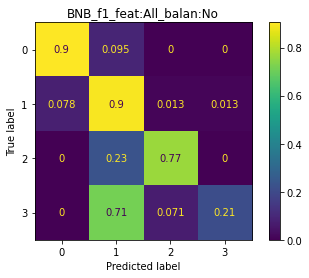

<Figure size 432x288 with 0 Axes>

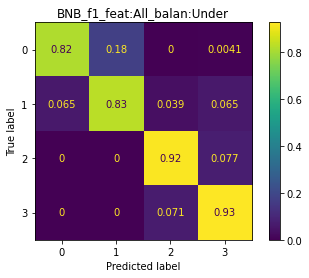

<Figure size 432x288 with 0 Axes>

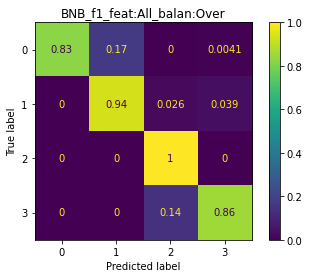

<Figure size 432x288 with 0 Axes>

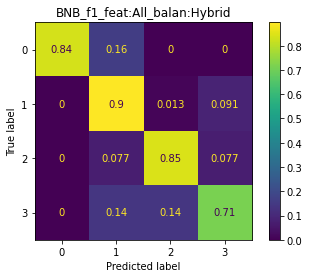

<Figure size 432x288 with 0 Axes>

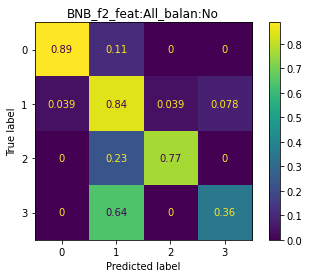

<Figure size 432x288 with 0 Axes>

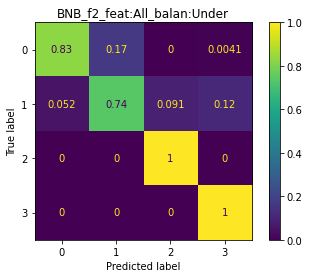

<Figure size 432x288 with 0 Axes>

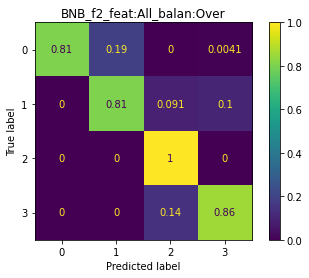

<Figure size 432x288 with 0 Axes>

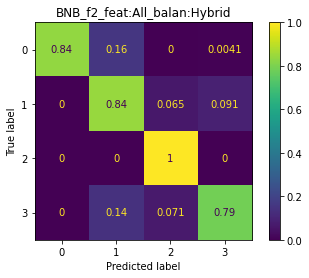

<Figure size 432x288 with 0 Axes>

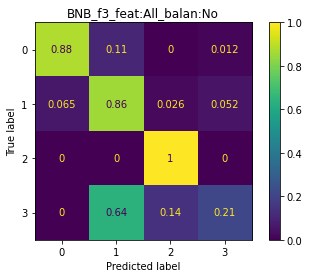

<Figure size 432x288 with 0 Axes>

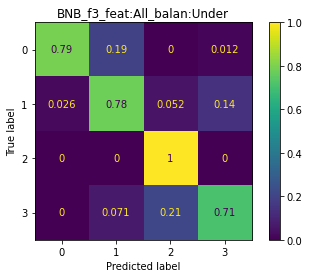

<Figure size 432x288 with 0 Axes>

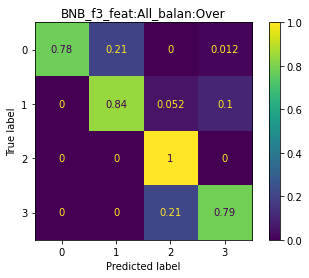

<Figure size 432x288 with 0 Axes>

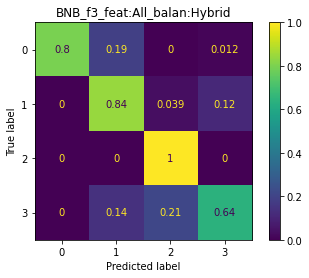

<Figure size 432x288 with 0 Axes>

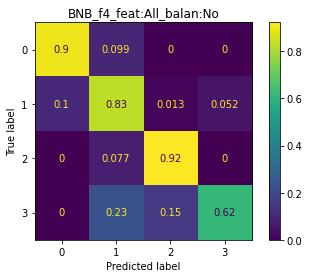

<Figure size 432x288 with 0 Axes>

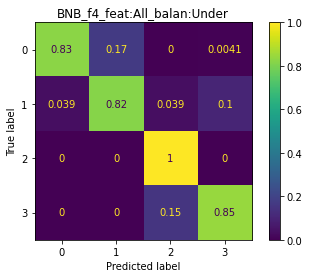

<Figure size 432x288 with 0 Axes>

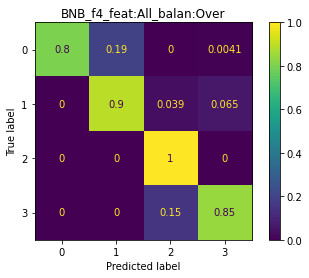

<Figure size 432x288 with 0 Axes>

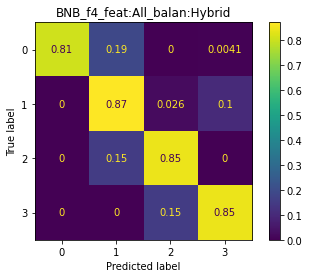

<Figure size 432x288 with 0 Axes>

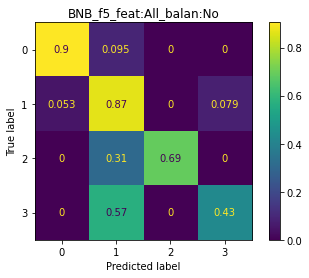

<Figure size 432x288 with 0 Axes>

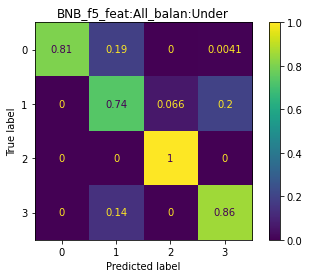

<Figure size 432x288 with 0 Axes>

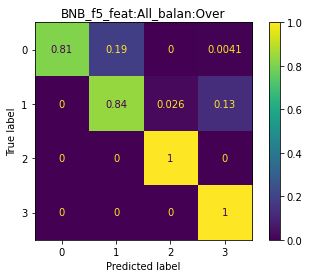

<Figure size 432x288 with 0 Axes>

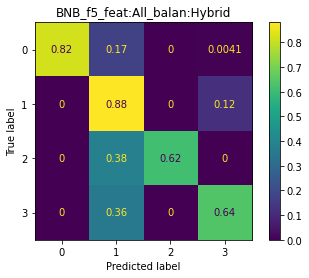

In [76]:
data_results = pd.DataFrame([],columns=['Acurácia', 'F1-Score', 'ROC-AUC', 'Fold','Modelo','Parâmetros',"Balanceamento","N_feat","Features"])
models = ["BNB"]#["KNN", "RL", "BNB", "DT", "PMC",  "RF", "GB"] #"KNN",
balances = ['No','Under', 'Over', 'Hybrid']
n_features = ["All"]#["All",16,11,6]#"All",

for name_model in models:
  results = []
  for k in range(1,6):

    #retira o banco de dados de teste
    teste  = data[data.fold==k]

    # ja separa o y de teste
    y_teste = teste['class']

    # o x de teste precisa ser definido posteriormente
    # uma vez que vai depender da seleção de features

    for balan in balances:
      
      treino = data[data.fold!=k] #retorna o banco de dados de treino balanceado

      #separação features e classes
      x_treino, y_treino = balan_func(treino[features],treino['class'],balan)



      # Econtrando os melhores hiper parâmetros
      b_model, best_parameters = grid_best_model(model=name_model, grid=grid)

      for n_feat in n_features:
        model= f_models(name_model,best_parameters)
        # print(model)
        #seleção de features para cada conjunto de hiper parâmetros 
        best_feat = select_feat(x_treino,y_treino,model,n_feat,features)

        #atualizando o treino com as features escolhidas
        x_treino =x_treino[best_feat]
        
        #definindo o x de teste a partir das features selecionadas
        x_teste = teste[best_feat]
        
        #treino do modelo com melhores parametros, features e balanceamento
        
        model.fit(x_treino, y_treino)

        # teste é feito sem balanceamento
        y_pred = model.predict(x_teste)
        y_pred_prob = model.predict_proba(x_teste)

        print("Modelo:", name_model)
        print("Melhor parametro:", best_parameters)         
        print("Fold", k, metrics(y_teste.values, y_pred, y_pred_prob))
        print('')
        plt.figure();
        plot_confusion_matrix(model, x_teste, y_teste, normalize='true');
        plt.title(name_model+'_f'+ str(k)+'_feat:'+str(n_feat)+'_balan:'+balan);
        #plt.savefig('/content/drive/MyDrive/AnalisePred_I/confusion_matrix_plus/'+ name_model+'_f'+ str(k) +'.pdf', format="pdf", dpi=1000, bbox_inches="tight");
        # plt.close();

        #del model


        result = metrics(y_teste, y_pred, y_pred_prob)
        result.append(k)
        result.append(name_model)
        result.append(best_parameters)

        result.append(balan)
        result.append(len(best_feat))
        result.append(best_feat)
        results.append(result)

        
  data_results = pd.concat([data_results, pd.DataFrame(results,columns=['Acurácia', 'F1-Score', 'ROC-AUC', 'Fold','Modelo','Parâmetros','Balanceamento',"N_feat","Features"])])
  #data_results.to_csv('/content/drive/MyDrive/AnalisePred_I/Car_results_plus'+ name_model + '.csv')


In [ ]:
model.tolist()

LogisticRegression(l1_ratio=0, random_state=0, tol=1e-05, warm_start=True)

In [ ]:
print(best_feat)

Index(['buying_price_vhigh', 'buying_price_high', 'buying_price_med',
       'buying_price_low', 'maintenance_price_vhigh', 'maintenance_price_high',
       'maintenance_price_med', 'maintenance_price_low', 'doors_2',
       'persons_2', 'persons_4', 'persons_more', 'luggage_boot_size_small',
       'safety_low', 'safety_med', 'safety_high'],
      dtype='object')
